### Capstone data integration: BiGCZ Portal searches, ODM2 SQLiteDB, CUAHSI WS

**Azavea/portal GeoProcessing API**  

https://staging.app.wikiwatershed.org/api/docs/

MMW staging users can now discover their API keys through the user interface, and test the MMW geoprocessing API on staging at will.

We've added an Account page with API key to the staging site. You will see it now if you go on staging, log in, and click on "Account" in the dropdown that appears when you click on your username in the top right. Your key is different between staging and production. We recommend that you use the staging key, and the staging version of the API (https://staging.app.wikiwatershed.org/api/docs/#!/api/Start_Rwd_POST) until the November release. This will enable you to test the latest fixes and ensure we get a ready-for-primetime version to production in the November release.

If using the API from the command line, just use the staging URL, as in:
curl -H "Content-Type: application/json" -H "Authorization: Token YOUR_API_KEY" -X POST -d '{ "location": [39.67185812402583,-75.76742706298828] }' https://staging.app.wikiwatershed.org/api/watershed/

We are mostly in cleanup mode for the API now, so no breaking changes are expected. We're working to add throttling, some input validation, and cleanup on the swagger documentation. 

In [1]:
%matplotlib inline

import json
import os
from datetime import datetime, timedelta
import pytz
import requests

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

import ulmo
from ulmo.util import convert_datetime

from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2rs

/opt/conda/envs/odm2client/lib/python2.7/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


## Geoprocessing API MMW / BiGCZ Portal: Extract drainage area

### Request JOB

In [2]:
# HIDE THIS
APIToken = 'Token f35a197701365d66197ad18ba37371a41dccb338'

In [3]:
headers = {
    'Authorization': APIToken,
    'Content-Type': 'application/json'
}

In [4]:
post_url = 'https://staging.app.wikiwatershed.org/api/watershed/'

In [5]:
payload = {
    'location': [40.746054, -111.847987], 
    'snappingOn': True, 
    'dataSource': 'nhd'}

json_dat = json.dumps(payload)

In [6]:
post_req = requests.post(post_url, data=json_dat, headers=headers)

json_out = json.loads(post_req.content)

### Get Job

In [7]:
get_url = 'https://staging.app.wikiwatershed.org/api/jobs/{job}/'.format

#### Is the job done (next request)?? If not, wait, and try it again manually

In [8]:
get_req = requests.get(get_url(job=json_out['job']), headers=headers)

In [13]:
result = json.loads(get_req.content)['result']

In [14]:
watershed = gpd.GeoDataFrame.from_features(result['watershed'], crs={'init': 'epsg:4326'})

In [15]:
# Initialize map
c = watershed.unary_union.centroid # GeoPandas heavy lifting
m = folium.Map(location=[c.y, c.x], tiles='CartoDB positron', zoom_start=12)

In [16]:
# Add Rapid Watershed Delineation onto map
folium.GeoJson(watershed).add_to(m);

---

## BiGCZ Portal Search result

### Extract search json from cuahsi data repository of 'water'

In [17]:
portal_pth = "../data"

In [18]:
portal_json_1 = "bigcz-cuahsi-water-slcretbuttecrk-2017-11-15.json"

In [19]:
portalcuahsi_json_pth = os.path.join(portal_pth, portal_json_1)

with open(portalcuahsi_json_pth, 'r') as fj:
    portalcuahsi_json = json.load(fj)

In [20]:
print('Number of sites: {}'.format(len(portalcuahsi_json)))

Number of sites: 21


In [21]:
portalcuahsi_json[0]

{u'active': False,
 u'author': None,
 u'begin_date': u'2013-06-19T13:45:00Z',
 u'categories': None,
 u'created_at': u'2013-06-19T13:45:00Z',
 u'description': u'iUTAH researchers have developed and deployed an ecohydrologic observatory to study water in \u2018Gradients Along Mountain to Urban Transitions\u2019 (GAMUT). The GAMUT Network measures aspects of climate, hydrology, and water quality along a mountain-to-urban gradient in three watersheds that share common water sources (winter-derived precipitation) but differ in the human and biophysical nature of land-use transitions. GAMUT includes state-of-the-art sensors at aquatic and terrestrial sites for real-time monitoring of common meteorological variables, snow accumulation and melt, soil moisture, surface water flow, and surface water quality.',
 u'details_url': None,
 u'end_date': u'2017-11-03T21:00:00Z',
 u'files': None,
 u'geom': {u'coordinates': [-111.807222, 40.780567], u'type': u'Point'},
 u'id': u'Red Butte Creek GAMUT:RB_A

In [22]:
len(portalcuahsi_json[0]['variables']), portalcuahsi_json[0]['variables'][0]

(71,
 {u'begin_date': u'2013-06-19T20:45:00.000Z',
  u'concept_keyword': u'Barometric pressure',
  u'data_type': u'Average',
  u'end_date': u'2017-11-15T05:00:00.000Z',
  u'id': u'iutah:BP_Avg',
  u'most_recent_value': u'83.3',
  u'name': u'Barometric pressure',
  u'sample_medium': u'Air',
  u'site': u'Red Butte Creek GAMUT:RB_ARBR_C',
  u'speciation': u'Not Applicable',
  u'units': u'kPa',
  u'wsdl': u'http://data.iutahepscor.org/RedButteCreekWOF/cuahsi_1_1.asmx'})

In [23]:
# Get only NWIS
for idx, e in enumerate(portalcuahsi_json):
    if 'NWIS' in e['service_code']:
        print(idx, e['id'], e['sample_mediums'], e['begin_date'], e['end_date'])

(14, u'NWISDV:10172200', [u'Surface water'], u'1963-10-01T00:00:00Z', u'2017-11-02T00:00:00Z')
(15, u'NWISUV:10172200', [u'Surface water'], u'1984-02-27T00:00:00Z', u'2017-11-02T00:00:00Z')
(16, u'NWISGW:404506111502401', [u'Groundwater'], u'1999-09-23T00:00:00Z', u'2017-06-30T00:00:00Z')
(19, u'NWISDV:10172220', [u'Surface water'], u'1979-12-28T00:00:00Z', u'1991-09-30T00:00:00Z')
(20, u'NWISGW:404502111502501', [u'Groundwater'], u'1934-10-15T00:00:00Z', u'1934-10-15T00:00:00Z')


In [24]:
# We'll pick 14 NWISDV:10172200 for time series visualization
dataset = portalcuahsi_json[14]
dataset

{u'active': False,
 u'author': None,
 u'begin_date': u'1963-10-01T00:00:00Z',
 u'categories': None,
 u'created_at': u'1963-10-01T00:00:00Z',
 u'description': u'The USGS National Water Information System (NWIS) provides access to millions of sites measuring streamflow, groundwater levels, and water quality. This web service provides methods for retrieving daily values data, such as discharge and water levels, from NWIS. For more information about NWIS data services, see http://waterservices.usgs.gov/',
 u'details_url': u'https://waterdata.usgs.gov/nwis/dv/?site_no=10172200',
 u'end_date': u'2017-11-02T00:00:00Z',
 u'files': None,
 u'geom': {u'coordinates': [-111.806045, 40.77994627], u'type': u'Point'},
 u'id': u'NWISDV:10172200',
 u'links': [{u'href': u'http://hiscentral.cuahsi.org/pub_network.aspx?n=1',
   u'type': u'service'},
  {u'href': u'https://waterdata.usgs.gov/nwis/dv/?site_no=10172200',
   u'type': u'details'}],
 u'sample_mediums': [u'Surface water'],
 u'scimeta': None,
 u'se

### Show folium map of "Portal Search" sites together with sites from the SQLite ODM2 Example 2 sqlite DB

In [25]:
marker_cluster = folium.MarkerCluster().add_to(m)

for e in portalcuahsi_json:
    folium.Marker(location=[e['geom']['coordinates'][1], e['geom']['coordinates'][0]], 
                  icon=folium.Icon(color='green'),
                  popup="{0} {1}".format(
                      e['id'], e['sample_mediums'])
                 ).add_to(marker_cluster)
    # print(e['id'], e['sample_mediums'])

### Get time series data from CUAHSI based on Portal JSON service information

In [26]:
def site_series_values_to_df(series_values, variable_name):
    # Create a clean timeseries list of (dt,val) tuples
    tsdt_tuplst = [(convert_datetime(valdict['datetime']).replace(tzinfo=pytz.utc), 
                    float(valdict['value']))
                   for valdict in series_values['values']]
    
    dt, val = zip(*tsdt_tuplst)
    ts_df = pd.DataFrame({'time':dt, variable_name:val})
    ts_df.set_index('time', inplace=True)
    ts_df.sort_index(ascending=True, inplace=True)
    return ts_df

In [27]:
# Extract information from the Portal JSON, for passing to WOF GetValues data request
wsdlurl = dataset['variables'][0]['wsdl'] + '?WSDL'
location = dataset['id']
variable = dataset['variables'][0]['id']
variable_name = dataset['variables'][0]['name']

In [28]:
wsdlurl, location, variable, variable_name

(u'http://hydroportal.cuahsi.org/nwisdv/cuahsi_1_1.asmx?WSDL',
 u'NWISDV:10172200',
 u'NWISDV:00060/DataType=MEAN',
 u'Discharge, cubic feet per second')

In [29]:
site_values = ulmo.cuahsi.wof.get_values(wsdlurl, location, variable, 
                                         start=dataset['begin_date'], end=dataset['end_date'])

/opt/conda/envs/odm2client/lib/python2.7/site-packages/ulmo/cuahsi/wof/core.py:170: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
/opt/conda/envs/odm2client/lib/python2.7/site-packages/ulmo/cuahsi/wof/core.py:173: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  end_datetime = util.convert_datetime(end)


In [30]:
ts_df = site_series_values_to_df(site_values, variable_name)
ts_df.tail()

/opt/conda/envs/odm2client/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


,"Discharge, cubic feet per second"
time,
2017-10-29 00:00:00+00:00,1.51
2017-10-30 00:00:00+00:00,1.51
2017-10-31 00:00:00+00:00,1.51
2017-11-01 00:00:00+00:00,1.53
2017-11-02 00:00:00+00:00,1.51


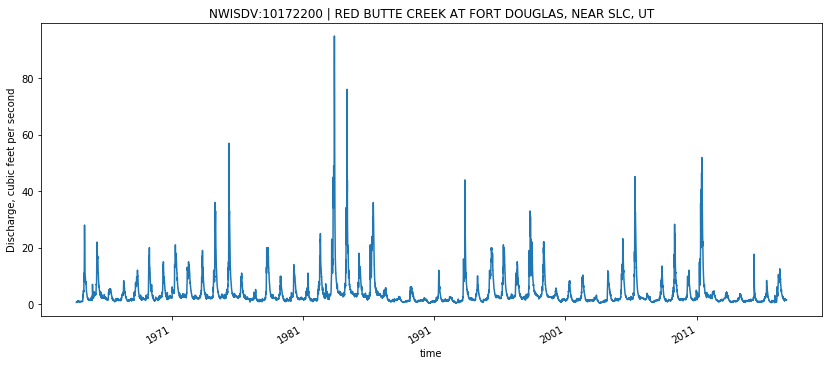

In [31]:
fig, ax = plt.subplots(figsize=(14, 6))
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', ax=ax)
ax.set_ylabel(varlabel)
ax.set_title("{} | {}".format(dataset['id'], dataset['title']));

---

## ODM2  Example 2 DATABASE

In [38]:
# Assign directory paths and SQLite file name
dpth = os.getcwd()
dbname_sqlite = "ODM2_Example2.sqlite"

# sqlite_pth = os.path.join(dpth, os.path.pardir, "data", dbname_sqlite)
sqlite_pth = os.path.join(dpth, os.path.pardir, "data/expectedoutput", dbname_sqlite)

In [39]:
try:
    session_factory = dbconnection.createConnection('sqlite', sqlite_pth, 2.0)
    read = odm2rs.ReadODM2(session_factory)
    print("Database connection successful!")
except Exception as e:
    print("Unable to establish connection to the database: ", e)

Database connection successful!


In [40]:
# Get all of the SamplingFeatures from the ODM2 database that are Sites
siteFeatures = read.getSamplingFeatures(type='Site')

# Read Sites records into a Pandas DataFrame
# ()"if sf.Latitude" is used only to instantiate/read Site attributes)
df = pd.DataFrame.from_records([vars(sf) for sf in siteFeatures if sf.Latitude])

In [41]:
# Create a GeoPandas GeoDataFrame from Sites DataFrame
ptgeom = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=ptgeom, crs={'init': 'epsg:4326'})
gdf.head(5)

,ElevationDatumCV,Elevation_m,FeatureGeometryWKT,Latitude,Longitude,SamplingFeatureCode,SamplingFeatureDescription,SamplingFeatureGeotypeCV,SamplingFeatureID,SamplingFeatureName,SamplingFeatureTypeCV,SamplingFeatureUUID,SiteTypeCV,SpatialReferenceID,_sa_instance_state,geometry
0,EGM96,1356.0,None,40.745078,-111.854449,RB_1300E,None,None,1,Red Butte Creek at 1300E (downstream of spring),Site,0DDE8EF6-EC2F-42C0-AB50-20C6C02E89B2,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.854449 40.745078)
1,EGM96,1356.0,None,40.745106,-111.854389,RB_1300ESpring,None,None,2,Spring that enters Red Butte Creek at 1300E,Site,9848BBFE-EA3F-4918-A324-13E8EDE5381C,Spring,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.854389 40.745106)
2,EGM96,1289.0,None,40.741583,-111.917667,RB_900W_BA,None,None,3,Red Butte Creek terminus at Jordan River at 13...,Site,688017BC-9E02-4444-A21D-270366BE2348,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.917667 40.741583)
3,EGM96,1519.0,None,40.766134,-111.826530,RB_Amphitheater,None,None,4,Red Butte Creek below Red Butte Garden Amphith...,Site,9CFE685B-5CDA-4E38-98D9-406D645C7D21,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.82653 40.766134)
4,EGM96,1648.0,None,40.779602,-111.806669,RB_ARBR_AA,None,None,5,Red Butte Creek above Red Butte Reservoir Adan...,Site,98C7F63A-FDFB-4898-87C6-5AA8EC34D1E4,Stream,1,<sqlalchemy.orm.state.InstanceState object at ...,POINT (-111.806669 40.779602)


In [42]:
marker_cluster2 = folium.MarkerCluster().add_to(m)

for idx, feature in gdf.iterrows():
    folium.Marker(location=[feature.geometry.y, feature.geometry.x], 
                  icon=folium.Icon(color='red'),
                  popup="ODM2 DB: {0} ({1}): {2}".format(
                      feature['SamplingFeatureCode'], feature['SiteTypeCV'], feature['SamplingFeatureName'])
                 ).add_to(marker_cluster2)

In [43]:
m

## Create combined time series from the two sources

In [51]:
allVars = read.getVariables()
variables_df = pd.DataFrame.from_records([vars(variable) for variable in allVars], index='VariableID')

relatedSite = read.getRelatedSamplingFeatures(sfid=26, relationshiptype='Was Collected at')[0]

In [47]:
def get_results_and_values(siteid, variablecode):
    v = variables_df[variables_df['VariableCode'] == variablecode]
    variableID = v.index[0]
    
    results = read.getResults(siteid=siteid, variableid=variableID, type="Measurement")
    resultIDList = [x.ResultID for x in results]
    resultValues = read.getResultValues(resultids=resultIDList)
    
    return resultValues, results

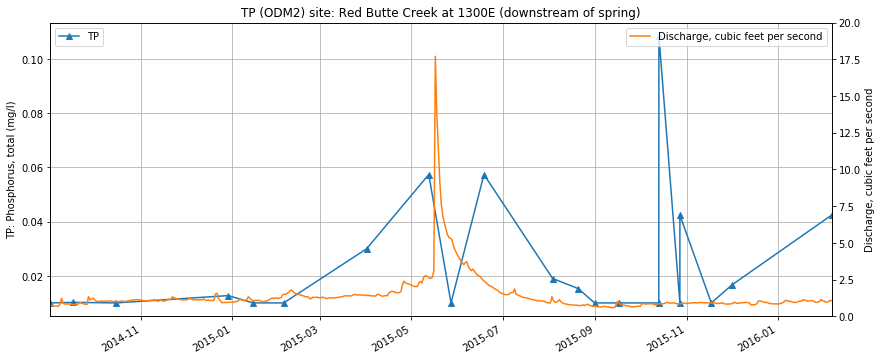

In [60]:
# Plot figure and axis set up (just *one* subplot, actually)
f, ax = plt.subplots(1, figsize=(14, 6))

# First plot (left axis)
siteID = 1  # Red Butte Creek at 1300 E (obtained from the getRelatedSamplingFeatures query)
VariableCode = 'TP'
resultValues_TP, results_TP = get_results_and_values(siteID, VariableCode)
xmin, xmax = resultValues_TP['valuedatetime'].min(), resultValues_TP['valuedatetime'].max()
plt.xlim(xmin, xmax)
resultValues_TP.plot(x='valuedatetime', y='datavalue', label=VariableCode, 
                     style='^-', kind='line', ax=ax)
ax.set_ylabel("{0}: {1} ({2})".format(VariableCode, results_TP[0].VariableObj.VariableNameCV, 
                                      results_TP[0].UnitsObj.UnitsAbbreviation))

# Second plot (right axis)
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', label=varlabel, ax=ax, 
                    secondary_y=True)
# ax.set_title("{} | {}".format(dataset['id'], dataset['title']));
plt.ylim(0, 20)
ax.right_ax.set_ylabel(varlabel)

# Tweak the figure
ax.legend(loc=2)
ax.right_ax.legend(loc=1)

ax.grid(True)
ax.set_xlabel('')
ax.set_title("TP (ODM2) site: {}".format(relatedSite.SamplingFeatureName));